In [1028]:
'''

'''
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image        #convert Images to tensor
from torch.utils.data import Dataset, DataLoader
import cv2

'''
from torch.autograd.variable import Variable
'''
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [1029]:
def get_hyperparameters():
    
    batch_size = 128
    learning_rate = 1e-3
    n_epochs = 5
    log_interval = 10
    momentum = 0.5
    
    return batch_size, learning_rate, n_epochs, log_interval, momentum

In [1030]:
def check_processor():
    
    if torch.cuda.is_available():
        print('using device: cuda')
    else:
        print('using device: cpu')

In [1031]:
def split_train_test_dataset(training_csv):
       
    train_paths, val_paths, train_labels, val_labels = train_test_split(training_csv["image_id"], training_csv["label"], test_size=0.2, random_state=42)
    
    return train_paths, val_paths, train_labels, val_labels

In [1032]:
class PaddyDataset(Dataset):
    
    def __init__(self, dataframe, label2id, root_dir, is_train, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.label2id = label2id
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,self.dataframe.iloc[idx, 1],
                                self.dataframe.iloc[idx, 0])
        
        image1 = cv2.imread(img_name)
        image = Image.fromarray(image1)
        
        if self.is_train:
            labelKey = self.dataframe.iloc[idx, 1]
            label = torch.tensor(int(self.label2id[labelKey]))  
        else:
            label =torch.tensor(1)

        if self.transform:
            image = self.transform(image)

        return image,label

In [1033]:
def get_label2id(training_csv):
    
    labelArr = training_csv['label'].unique()
    label2id = {}
    id2label = {}
    index = 0
    for  class_name in labelArr:
        label2id[class_name] = str(index)
        id2label[str(index)] = class_name
        index=index +1
    print(label2id)
  
    return label2id, id2label

In [1034]:
def EDA(paddy_dataset, images, labels, training_csv):
    
    print("EDA:", "\n")
          
    print("Training Dataset size:", len(paddy_dataset))
    print("Label Distribution:", paddy_dataset['label'].value_counts(), "\n")
    
    print("Image size (channel, height, width):", images[0].shape, "\n")
    print("Visualization of batch #1:")
    print("-------------------------\n")
    print("labels:\n", labels, len(labels), "\n")
    print("First 5 pictures in batch #1:")

In [1035]:
def plot(images, labels, id2label):
    
    plt.subplots(figsize=(15, 15))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.tight_layout()
        plt.axis("off"); plt.xticks([]) ; plt.yticks([]) 
        plt.title("Ground Truth: {}".format(labels[i]))
        
        images_rgb = images[i].squeeze()
        images_rgb = (np.transpose(images_rgb, (0, 2, 1)).T).detach().numpy()

        plt.imshow(cv2.cvtColor(images_rgb, cv2.COLOR_BGR2RGB))
        
    plt.show()

In [1036]:
def train_model(n_epochs, model, train_loader, optimizer, log_interval):
    
    model.train()
    
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()                           
        output = model(data)                   
        loss = F.nll_loss(output, target)               
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(n_epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    
    total_time = time.time() - start_time
    print("Total running time:", total_time)

9886 521
{'bacterial_leaf_blight': '0', 'bacterial_leaf_streak': '1', 'bacterial_panicle_blight': '2', 'blast': '3', 'brown_spot': '4', 'dead_heart': '5', 'downy_mildew': '6', 'hispa': '7', 'normal': '8', 'tungro': '9'}
id2label bacterial_leaf_blight
label2id {'bacterial_leaf_blight': '0', 'bacterial_leaf_streak': '1', 'bacterial_panicle_blight': '2', 'blast': '3', 'brown_spot': '4', 'dead_heart': '5', 'downy_mildew': '6', 'hispa': '7', 'normal': '8', 'tungro': '9'}
EDA: 

Training Dataset size: 9886
Label Distribution: normal                      1683
blast                       1651
hispa                       1498
dead_heart                  1370
tungro                      1036
brown_spot                   913
downy_mildew                 586
bacterial_leaf_blight        463
bacterial_leaf_streak        363
bacterial_panicle_blight     323
Name: label, dtype: int64 

Image size (channel, height, width): torch.Size([3, 224, 224]) 

Visualization of batch #1:
------------------------

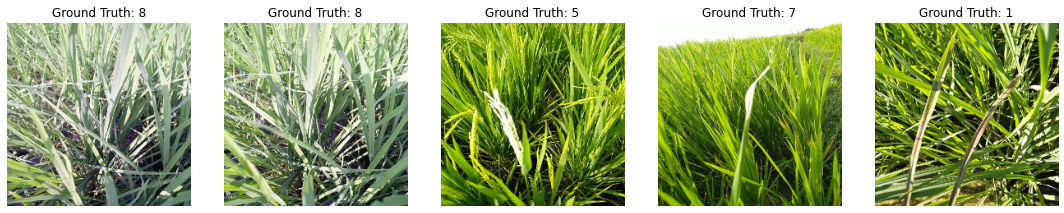

using device: cpu


In [ ]:
'''
for dirname, _, filenames in os.walk('../input/paddy-doctor/train_images'):
    for filename in filenames:
        img = Image.open(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename), img.size)       #img size: 480 x 640
'''        
def main(argv):

    # -------- Prepare dataset
    torch.manual_seed(42)  
    torch.backends.cudnn.enabled = False
    
    batch_size, learning_rate, n_epochs, log_interval, momentum  = get_hyperparameters()

    training_csv = pd.read_csv("../input/paddy-doctor/train.csv")
    train, valid = train_test_split(training_csv, test_size=0.05,random_state=0)
    print(len(train), len(valid))
    
    label2id, id2label = get_label2id(training_csv)
    a = '0'
    print("id2label", id2label[a])
    print("label2id", label2id)

    transform_dataset = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
    
    train_dataset = PaddyDataset(train, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)
    valid_dataset = PaddyDataset(valid, label2id, root_dir='../input/paddy-doctor/train_images', is_train=True, transform=transform_dataset)

    dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, num_workers=2, shuffle=True)
    
    images, labels = next(iter(dataloader))
    
    EDA(train, images, labels, training_csv)
    plot(images, labels, id2label)
    check_processor()
    
    # --------- Define model
    resnet = models.resnet34(pretrained=True)
    
    resnet.fc =  nn.Sequential(nn.Dropout(0.1),
                               nn.Linear(512, 10))

    optimizer = optim.SGD(resnet.parameters(), lr=learning_rate, momentum=momentum)
    
    train_model(n_epochs, resnet, dataloader, optimizer, log_interval)
        
    return

if __name__ == "__main__":
    main(sys.argv)


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session